# Video metrics

In [121]:
import json
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import math
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
import subprocess
import csv
import seaborn as sns

## Ground truth

In [122]:
TEST_SET_PATH = '/media/rodri/Files/Datasets/Real_dataset/'
test_labels = '/media/rodri/Files/Datasets/Real_dataset/test_data.csv'
df_labels = pd.read_csv(test_labels)

In [123]:
df_labels.head()

,path,class,video
0,images/guns/video_1/background/image_1.png,0,1_0_1
1,images/guns/video_1/background/image_2.png,0,1_0_1
2,images/guns/video_1/background/image_3.png,0,1_0_1
3,images/guns/video_1/background/image_4.png,0,1_0_1
4,images/guns/video_1/background/image_5.png,0,1_0_1


## Predictions

In [124]:
## Model variables
ROBOFLOW_MODELS = [
    'yolov5', # 1
    'yolov7', # 2 
    'yolos', # 3 
    'yolov8s', # 4
    'no_version', # 5
    'no_version', # 6
    'error_uploading', # 7
    'yolov5s_data_augmentation', # 8
    'yolov5n_data_augmentation', # 9
]

MODEL_VERSION = 9

OUT_DATA_PATH = TEST_SET_PATH

# Create and set output path
os.makedirs(os.path.join(OUT_DATA_PATH, 'reports', ROBOFLOW_MODELS[MODEL_VERSION-1], 'metrics'), exist_ok=True)

OUTPUT_PATH = os.path.join(OUT_DATA_PATH, 'reports', ROBOFLOW_MODELS[MODEL_VERSION-1], 'metrics')

In [125]:
BASE_CURL = 'base64 ${file} | curl -d "@-" "http://localhost:9001/thesis-gun-knife/{{MODEL_VERSION}}?api_key=DmyTMwALZb1Ah6cKptuz"'
BASE_CURL = BASE_CURL.replace('{{MODEL_VERSION}}', str(MODEL_VERSION))
BASE_CURL

'base64 ${file} | curl -d "@-" "http://localhost:9001/thesis-gun-knife/9?api_key=DmyTMwALZb1Ah6cKptuz"'

In [126]:
def get_annotations_from_image(image: str) -> list:
    """ Get annotations from images

    Args:
        model (ObjectDetectionModel): Model to use
        image (str): Image path to predict
        
    Returns:
        list: List of annotations
    """
    annotations = []
    annotations = subprocess.check_output(BASE_CURL.replace('${file}', image), shell=True)
    try:
        annotations = json.loads(annotations)
        annotations = annotations['predictions']
    except Exception as e:
        annotations = []
        print(f'Error: {e} in file {image}')
        raise StopIteration
        
    def convert_yolo_prediction_to_voc(annotations: list)->list:
        new_annotations = []
        try:
            assert len(annotations) > 0, 'No annotations'
            for annotation in annotations:            
                class_id = annotation['class']
                
                x = annotation['x']
                y = annotation['y']
                w = annotation['width']
                h = annotation['height']
                
                xmin = math.floor(x - (w / 2)+1)
                ymin = math.floor(y - (h / 2)+1)
                xmax = math.floor(x + (w / 2)+1)
                ymax = math.floor(y + (h / 2)+1)
                
                new_annotations.append({
                    'path': image,
                    'class': 2 if class_id == 'knife' else (1 if class_id == 'gun' else 0),
                    'bbox':{
                        'xmin': xmin,
                        'ymin': ymin,
                        'xmax': xmax,
                        'ymax': ymax
                    },
                    'conf': annotation['confidence']
                })
            
            return new_annotations
        except AssertionError:
            return [
                {
                    'path': image,
                    'class': 0,
                    'bbox':{
                        'xmin': 0,
                        'ymin': 0,
                        'xmax': 0,
                        'ymax': 0
                    },
                    'conf': 0
                }
            ]

    return convert_yolo_prediction_to_voc(annotations)
    

# Test case
# image_path = '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/101516494_5781_jpg.rf.90ba3800fa4ed5e25aa2ed5b3dbbc221.jpg'
# annotations = get_annotations_from_image(image_path)
# print(annotations)
# image_path = '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000002466.jpg'
# annotations = get_annotations_from_image(image_path)
# print(annotations)
# image_path = '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/11_12_1565_jpg.rf.95d9be65da98b4d65450e527aec902ba.jpg'
# annotations = get_annotations_from_image(image_path)
# print(annotations)
# image_path = '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/batch_40_jpg.rf.d083c576c8cf66569711b7eab35f2df5.jpg'
# annotations = get_annotations_from_image(image_path)
# print(annotations)

In [127]:
test_predictions = []
for path in tqdm((TEST_SET_PATH+x for x in df_labels['path']), desc='Predicting images', total=1294):
    # print('Image path:', path)
    annotations = get_annotations_from_image(os.path.join(test_labels, path))
    # print('Annotations', end=': ')
    # print(annotations)
    test_predictions.append(annotations)

Predicting images:   0%|          | 0/1294 [00:00<?, ?it/s]  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1309k  100    92  100 1309k    191  2722k --:--:-- --:--:-- --:--:-- 2716k
Predicting images:   0%|          | 1/1294 [00:00<16:54,  1.27it/s]  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1372k  100    92  100 1372k    184  2755k --:--:-- --:--:-- --:--:-- 2755k
Predicting images:   0%|          | 2/1294 [00:01<16:18,  1.32it/s]  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1395k  100    92  100 1395k    280  4254k --:--:-- --:--:-- --:--:-- 4254k
Predicting images:   0%|          | 3/1294 [00:01<13:13,  1.63it/s]  % Total    % Received % Xfe

In [128]:
## Save predictions in a json file
with open(os.path.join(OUTPUT_PATH, 'test_predictions.json'), 'w') as f:
    json.dump(test_predictions, f)

## Reading test_labels

In [143]:
## Read json file and convert to dataframe

with open(os.path.join(OUTPUT_PATH, 'test_predictions.json'), 'r') as f:
    test_predictions = json.load(f)
    
test_predictions = [item[0] for item in test_predictions]
test_predictions = pd.DataFrame(test_predictions)
test_predictions

,path,class,bbox,conf
0,/media/rodri/Files/Datasets/Real_dataset/image...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
1,/media/rodri/Files/Datasets/Real_dataset/image...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
2,/media/rodri/Files/Datasets/Real_dataset/image...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
3,/media/rodri/Files/Datasets/Real_dataset/image...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
4,/media/rodri/Files/Datasets/Real_dataset/image...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
...,...,...,...,...
1435,/media/rodri/Files/Datasets/Real_dataset/image...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
1436,/media/rodri/Files/Datasets/Real_dataset/image...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
1437,/media/rodri/Files/Datasets/Real_dataset/image...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
1438,/media/rodri/Files/Datasets/Real_dataset/image...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0


## Merge dataframes

In [130]:
## Fix path from labels
df_labels['path'] = df_labels['path'].apply(lambda x: TEST_SET_PATH+x)

In [131]:
df_labels

,path,class,video
0,/media/rodri/Files/Datasets/Real_dataset/image...,0,1_0_1
1,/media/rodri/Files/Datasets/Real_dataset/image...,0,1_0_1
2,/media/rodri/Files/Datasets/Real_dataset/image...,0,1_0_1
3,/media/rodri/Files/Datasets/Real_dataset/image...,0,1_0_1
4,/media/rodri/Files/Datasets/Real_dataset/image...,0,1_0_1
...,...,...,...
1435,/media/rodri/Files/Datasets/Real_dataset/image...,2,1_12_0
1436,/media/rodri/Files/Datasets/Real_dataset/image...,2,1_12_0
1437,/media/rodri/Files/Datasets/Real_dataset/image...,2,1_12_0
1438,/media/rodri/Files/Datasets/Real_dataset/image...,2,1_12_0


In [132]:
test_predictions.head()

,path,class,bbox,conf
0,/media/rodri/Files/Datasets/Real_dataset/image...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
1,/media/rodri/Files/Datasets/Real_dataset/image...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
2,/media/rodri/Files/Datasets/Real_dataset/image...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
3,/media/rodri/Files/Datasets/Real_dataset/image...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
4,/media/rodri/Files/Datasets/Real_dataset/image...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0


In [144]:
## Merge labels and predictions
df_total = pd.merge(df_labels, test_predictions, on='path', how='left')
df_total

,path,class_x,video,class_y,bbox,conf
0,/media/rodri/Files/Datasets/Real_dataset/image...,0,1_0_1,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
1,/media/rodri/Files/Datasets/Real_dataset/image...,0,1_0_1,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
2,/media/rodri/Files/Datasets/Real_dataset/image...,0,1_0_1,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
3,/media/rodri/Files/Datasets/Real_dataset/image...,0,1_0_1,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
4,/media/rodri/Files/Datasets/Real_dataset/image...,0,1_0_1,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
...,...,...,...,...,...,...
1435,/media/rodri/Files/Datasets/Real_dataset/image...,2,1_12_0,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
1436,/media/rodri/Files/Datasets/Real_dataset/image...,2,1_12_0,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
1437,/media/rodri/Files/Datasets/Real_dataset/image...,2,1_12_0,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0
1438,/media/rodri/Files/Datasets/Real_dataset/image...,2,1_12_0,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.0


In [134]:
df_total['path'][0]

'/media/rodri/Files/Datasets/Real_dataset/images/guns/video_1/background/image_1.png'

In [146]:
true_y = [] # True labels: Get first class from each video
pred_y = [] # Predicted labels: Get first class greater than 0 with confidence greater than 0.4 else 0
conf_y = [] # Confidence of predicted labels
videos = set(df_total['video']) # Get unique videos

for video in tqdm(videos, desc='Getting true and predicted labels'):
    df_video = df_total[df_total['video'] == video]
    true_y.append(df_video['class_x'].values[0])
    pred_y.append(0 if len(df_video[df_video['conf'] >= 0.4]) == 0 else df_video[df_video['conf'] >= 0.4]['class_y'].values[0])
    conf_y.append(0 if len(df_video[df_video['conf'] >= 0.4]) == 0 else df_video[df_video['conf'] >= 0.4]['conf'].values[0])

Getting true and predicted labels: 100%|██████████| 40/40 [00:00<00:00, 264.46it/s]


## Get video metrics

In [136]:
# Print true and predicted labels
# for i, j, k in zip(true_y, pred_y, conf_y):
#     print(i, j, k)

In [147]:
# Confusion matrix from two lists
def confusion_matrix(true_y: list, pred_y: list, labels: list) -> np.ndarray:
    """ Confusion matrix from two lists

    Args:
        true_y (list): True labels
        pred_y (list): Predicted labels
        labels (list): Labels to use
        
    Returns:
        np.ndarray: Confusion matrix
    """
    cm = np.zeros((len(labels), len(labels)))
    for i, j in zip(true_y, pred_y):
        cm[i][j] += 1
    return cm

# Confusion matrix
cm = confusion_matrix(true_y, pred_y, [0, 1, 2])
cm

array([[14.,  6.,  0.],
       [ 0., 10.,  0.],
       [ 1.,  7.,  2.]])

In [148]:
## Plot confusion matrix with pandas and seaborn
confusion_matrix = pd.DataFrame(cm, index=['No weapon', 'Gun', 'Knife'], columns=['No weapon', 'Gun', 'Knife'])
confusion_matrix

,No weapon,Gun,Knife
No weapon,14.0,6.0,0.0
Gun,0.0,10.0,0.0
Knife,1.0,7.0,2.0


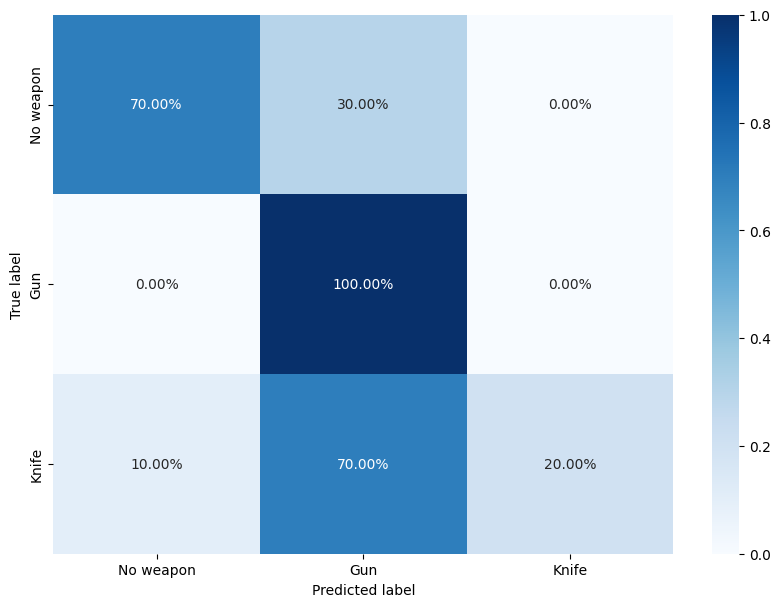

In [149]:
# Confusion matrix percentage using seaborn NOTE: the confusion matrix is transposed
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix/cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

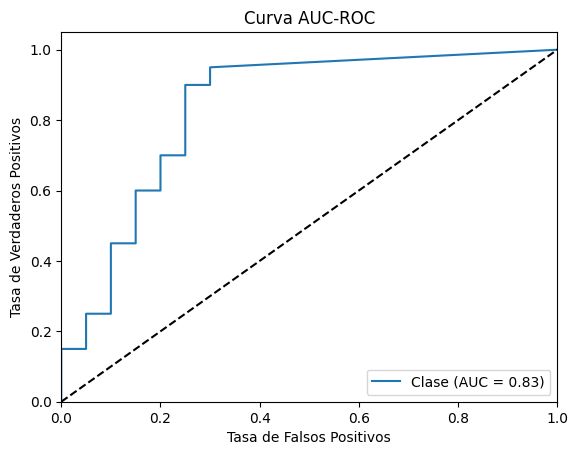

In [150]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Obtener las predicciones de probabilidad del modelo
y_true_roc = [0 if x == 0 else 1 for x in true_y]
y_pred_proba = conf_y

# Calcular la curva ROC y el área bajo la curva (AUC)
fpr, tpr, _ = roc_curve(y_true_roc, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, label='Clase (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva AUC-ROC')
plt.legend(loc="lower right")
plt.show()


In [151]:
# Classification report
print(classification_report(true_y, pred_y, target_names=['No weapon', 'Gun', 'Knife']))

              precision    recall  f1-score   support

   No weapon       0.93      0.70      0.80        20
         Gun       0.43      1.00      0.61        10
       Knife       1.00      0.20      0.33        10

    accuracy                           0.65        40
   macro avg       0.79      0.63      0.58        40
weighted avg       0.83      0.65      0.63        40



In [152]:
# print accuracy & Precision & Recall & F1-score
print('{:.2f}'.format(accuracy_score(true_y, pred_y)), end=' & ')
print('{:.2f}'.format(precision_score(true_y, pred_y, average='macro')), end=' & ')
print('{:.2f}'.format(recall_score(true_y, pred_y, average='macro')), end=' & ')
print('{:.2f}'.format(f1_score(true_y, pred_y, average='macro')))

0.65 & 0.79 & 0.63 & 0.58
